In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
 
from datetime import datetime,timedelta
import datetime as dt

## **OBJECTIVE: 'Build a profitable tennis betting algorithm'**



1. Build a binary classification model that returns the probability for player A or player B to win. 

2. Check the prediction against the most profitable bookmakers and calculate the expected profit:

> A. Build some confidence metrics -> ratio  between our win probability and the bookmaker win probability.

> B. Set a solid threshold (avoiding overfitting as much as possible) to tell on which game we want to bet.

> C. Forecast and plot the expected profit on the games we have selected to bet on.


# **Data exploration, selection and creation**

In [2]:
# DATA Collection

urls = ['https://raw.githubusercontent.com/GuillaumeRouja/2021-Tennis_Bet/main/Data/2010.csv','https://raw.githubusercontent.com/GuillaumeRouja/2021-Tennis_Bet/main/Data/2011.csv',
        'https://raw.githubusercontent.com/GuillaumeRouja/2021-Tennis_Bet/main/Data/2012.csv','https://raw.githubusercontent.com/GuillaumeRouja/2021-Tennis_Bet/main/Data/2013.csv',
        'https://raw.githubusercontent.com/GuillaumeRouja/2021-Tennis_Bet/main/Data/2014.csv','https://raw.githubusercontent.com/GuillaumeRouja/2021-Tennis_Bet/main/Data/2015.csv',
        'https://raw.githubusercontent.com/GuillaumeRouja/2021-Tennis_Bet/main/Data/2016.csv','https://raw.githubusercontent.com/GuillaumeRouja/2021-Tennis_Bet/main/Data/2017.csv',
        'https://raw.githubusercontent.com/GuillaumeRouja/2021-Tennis_Bet/main/Data/2018.csv','https://raw.githubusercontent.com/GuillaumeRouja/2021-Tennis_Bet/main/Data/2019.csv',
        'https://raw.githubusercontent.com/GuillaumeRouja/2021-Tennis_Bet/main/Data/2020.csv','https://raw.githubusercontent.com/GuillaumeRouja/2021-Tennis_Bet/main/Data/2021.csv']

dfs = [pd.read_csv(url,sep=';') for url in urls]
data = pd.concat(dfs, ignore_index=True)

# Keep colums we need -> Only keep data known at game time 

data.drop(['WPts','LPts','W1','L1','W2','L2','W3','L3','W4','L4','W5','L5','Wsets','Lsets','EXW','EXL','LBW','LBL','SJW','SJL','MaxW','MaxL','AvgW','AvgL'],axis=1,inplace=True)

#Format adjustment

data.PSW= (data.PSW.replace(',','.', regex=True).astype(float))
data.PSL= (data.PSL.replace(',','.', regex=True).astype(float))
data.B365W= (data.B365W.replace(',','.', regex=True).astype(float))
data.B365L= (data.B365L.replace(',','.', regex=True).astype(float)) 

data['Date'] = pd.to_datetime(data.Date,dayfirst=True)

data.sort_values(['Date'], inplace=True)
data=data.reset_index(drop=True)

In [3]:
# After various accuracy tests, and given important chunk of information are missing before 2015, we will start the study from 2015.

# Data selection

beg=datetime(2015,1,1) 
end=datetime(2021,12,31)

indices=data[(data.Date>beg)&(data.Date<=end)].index
data=data.iloc[indices,:]

print("Number of games since Jan'2015: ",len(data))

data.sort_values(['Date'], inplace=True)
data=data.reset_index(drop=True)

Number of games since Jan'2015:  16588


In [4]:
data.head()

,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,Loser,WRank,LRank,Comment,B365W,B365L,PSW,PSL
0,2,Chennai,Chennai Open,2015-01-05,ATP250,Outdoor,Hard,1st Round,3,Muller G.,Roger-Vasselin E.,46.0,116.0,Completed,1.66,2.10,1.81,2.10
1,1,Brisbane,Brisbane International,2015-01-05,ATP250,Outdoor,Hard,1st Round,3,Chardy J.,Golubev A.,31.0,72.0,Completed,1.28,3.50,1.34,3.50
2,1,Brisbane,Brisbane International,2015-01-05,ATP250,Outdoor,Hard,1st Round,3,Kokkinakis T.,Benneteau J.,149.0,25.0,Completed,2.62,1.44,2.67,1.53
3,1,Brisbane,Brisbane International,2015-01-05,ATP250,Outdoor,Hard,1st Round,3,Duckworth J.,Simon G.,125.0,21.0,Completed,4.50,1.18,4.67,1.23
4,3,Doha,Qatar Exxon Mobil Open,2015-01-05,ATP250,Outdoor,Hard,1st Round,3,Brown D.,Lorenzi P.,98.0,63.0,Completed,1.53,2.37,1.57,2.55


# Elo Ranking computing #

We chose to introduce an Elo Calculation, in addition to the ATP ranking:

Elo ranking is calculated on the more recent games and gives a higher ranking (by granting more points) to the player who has defeated another player of a superior rank. Therefore, this calculation is a better indicator of the current shape of a given player.

-> Proba elo = probability of a given player A winning according to it Elo.

- if elo_player A = elo_player B, the probability is 50%
- if elo_player A > elo_player B, the probability is >50%
- if elo_player A < elo_player B, the probability is <50%

Example: +100 points = 64% chance of winning / +200 points = 76%

In [5]:
def compute_elo_rankings(data):
    """
    Given the list of matches in chronological order, for each match, computes 
    the elo ranking of the 2 players at the beginning of the match
    
    """
    print("Elo rankings computing...")
    players=list(pd.Series(list(data.Winner)+list(data.Loser)).value_counts().index) # Gather all players from data
    elo=pd.Series(np.ones(len(players))*1500,index=players) # Attribute Elo Ranking of 1500 to each player
    ranking_elo=[(1500,1500)]
    for i in range(1,len(data)):
        w=data.iloc[i-1,:].Winner   # Select Winner and Loser of the previous game
        l=data.iloc[i-1,:].Loser
        elow=elo[w]  
        elol=elo[l]
        pwin=1 / (1 + 10 ** ((elol - elow) / 400))  # Win prob resulting from elo. Ex: elol = 1900, elow = 2000. Delta = 100 -> winner prob = 64%
        K_win=32
        K_los=32
        new_elow=elow+K_win*(1-pwin) # The winner has his elo increased by K_win*(1-pwin). Ex: 1500 + 32*(1-0.64) = 1511.52. 
        new_elol=elol-K_los*(1-pwin) # A victory against a better ranked player grants more points.
        elo[w]=new_elow
        elo[l]=new_elol
        ranking_elo.append((elo[data.iloc[i,:].Winner],elo[data.iloc[i,:].Loser])) 
        if i%3000==0:
            print(str(i)+" matches computed...")
    ranking_elo=pd.DataFrame(ranking_elo,columns=["elo_winner","elo_loser"]) 
    ranking_elo["p_elo_winner"]=1 / (1 + 10 ** ((ranking_elo["elo_loser"] - ranking_elo["elo_winner"]) / 400))   
    ranking_elo["p_elo_loser"]=1 / (1 + 10 ** ((ranking_elo["elo_winner"] - ranking_elo["elo_loser"]) / 400))
    return ranking_elo

# Computing of the elo ranking of each player at the beginning of each match.

elo_rankings = compute_elo_rankings(data)
data = pd.concat([data,elo_rankings],1)

Elo rankings computing...
3000 matches computed...
6000 matches computed...
9000 matches computed...
12000 matches computed...
15000 matches computed...


# Initial analysis #

In [6]:
data.head()

,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,Loser,WRank,LRank,Comment,B365W,B365L,PSW,PSL,elo_winner,elo_loser,p_elo_winner,p_elo_loser
0,2,Chennai,Chennai Open,2015-01-05,ATP250,Outdoor,Hard,1st Round,3,Muller G.,Roger-Vasselin E.,46.0,116.0,Completed,1.66,2.10,1.81,2.10,1500.0,1500.0,0.5,0.5
1,1,Brisbane,Brisbane International,2015-01-05,ATP250,Outdoor,Hard,1st Round,3,Chardy J.,Golubev A.,31.0,72.0,Completed,1.28,3.50,1.34,3.50,1500.0,1500.0,0.5,0.5
2,1,Brisbane,Brisbane International,2015-01-05,ATP250,Outdoor,Hard,1st Round,3,Kokkinakis T.,Benneteau J.,149.0,25.0,Completed,2.62,1.44,2.67,1.53,1500.0,1500.0,0.5,0.5
3,1,Brisbane,Brisbane International,2015-01-05,ATP250,Outdoor,Hard,1st Round,3,Duckworth J.,Simon G.,125.0,21.0,Completed,4.50,1.18,4.67,1.23,1500.0,1500.0,0.5,0.5
4,3,Doha,Qatar Exxon Mobil Open,2015-01-05,ATP250,Outdoor,Hard,1st Round,3,Brown D.,Lorenzi P.,98.0,63.0,Completed,1.53,2.37,1.57,2.55,1500.0,1500.0,0.5,0.5


In [7]:
# ATP column is redundant with the columns 'Tournament' and 'Location'

data.drop('ATP',axis=1,inplace=True)

Most columns are self-explanatory:
- Best of : Number of sets (either 3 or 5)
- Wrank, LRank : Loser and Winer ATP ranks
- Comment : status of the game (Completed, Retired, Walkover, Awarded, sched, Disqualified)
- B365W, B365L, PSW, PSL : Bookmakers odds
- Elo, p_elo: (see Preliminary comments)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16588 entries, 0 to 16587
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Location      16588 non-null  object        
 1   Tournament    16588 non-null  object        
 2   Date          16588 non-null  datetime64[ns]
 3   Series        16588 non-null  object        
 4   Court         16588 non-null  object        
 5   Surface       16588 non-null  object        
 6   Round         16588 non-null  object        
 7   Best of       16588 non-null  int64         
 8   Winner        16588 non-null  object        
 9   Loser         16588 non-null  object        
 10  WRank         16579 non-null  float64       
 11  LRank         16544 non-null  float64       
 12  Comment       16588 non-null  object        
 13  B365W         16533 non-null  float64       
 14  B365L         16534 non-null  float64       
 15  PSW           16516 non-null  float6

# Outliers and absurd values check #

In [9]:
data.describe()

,Best of,WRank,LRank,B365W,B365L,PSW,PSL,elo_winner,elo_loser,p_elo_winner,p_elo_loser
count,16588.000000,16579.000000,16544.000000,16533.000000,16534.000000,16516.000000,16516.000000,16588.000000,16588.000000,16588.000000,16588.000000
mean,3.412708,58.942880,87.829001,1.857593,3.490242,1.937264,3.810045,1626.155436,1569.765313,0.567136,0.432864
std,0.809400,71.864839,107.707028,1.209518,3.687970,1.282899,4.191151,148.225719,114.323958,0.177204,0.177204
min,3.000000,1.000000,1.000000,0.971000,0.967000,0.974000,1.010000,1320.828365,1330.497710,0.024399,0.015111
25%,3.000000,17.000000,34.000000,1.250000,1.660000,1.290000,1.780000,1513.127343,1489.722106,0.450950,0.305464
50%,3.000000,42.000000,63.000000,1.530000,2.500000,1.570000,2.560000,1594.520076,1542.000821,0.559953,0.440047
75%,3.000000,77.000000,101.000000,2.100000,3.750000,2.160000,4.000000,1711.215398,1627.588134,0.694536,0.549050
max,5.000000,1821.000000,1821.000000,34.000000,101.000000,31.300000,81.000000,2135.387959,2144.430885,0.984889,0.975601


In [10]:

# B365 minimum odds equal 1 but we know odds need to be >1, otherwise there is no incentive to bet.

data = data[(data.PSW >1)&(data.PSL>1)&(data.B365W>1)&(data.B365W>1)]

# ATP rankings cannot be 0.

data = data[(data.WRank != 0) & (data.LRank != 0)]

In [11]:
# 'Comment' Feature:

data.Comment.value_counts()

Completed       15931
Retired           469
Walkover           93
Awarded             2
Rrtired             1
Sched               1
Disqualified        1
Name: Comment, dtype: int64

In [12]:
# We try to limit the number of random circumstances as much as possible in order to build a cleaner prediction so we have chosen to focus on 'Completed' games only.

data = data[data.Comment == 'Completed']
data.drop('Comment',axis=1,inplace=True)

In [13]:
data.nunique()

Location           89
Tournament        114
Date             1795
Series              5
Court               2
Surface             3
Round               8
Best of             2
Winner            420
Loser             602
WRank             418
LRank             624
B365W              80
B365L              83
PSW               600
PSL              1244
elo_winner      15642
elo_loser       15385
p_elo_winner    15764
p_elo_loser     15764
dtype: int64

Our dataset is made of 417 distinct winners and 599 distinct losers. Winners list includes Loser names and vice versa.

In [14]:
data.isnull().sum()

Location         0
Tournament       0
Date             0
Series           0
Court            0
Surface          0
Round            0
Best of          0
Winner           0
Loser            0
WRank            9
LRank           39
B365W            0
B365L            0
PSW              0
PSL              0
elo_winner       0
elo_loser        0
p_elo_winner     0
p_elo_loser      0
dtype: int64

In [15]:
# Remove remaining NaNs

data.dropna(axis=0,inplace=True)

In [16]:
# Before we conclude this initial part and freeze the core data of our analysis, we need to pay attention to the type of Rounds:

data.Round.value_counts()

1st Round        7089
2nd Round        4549
Quarterfinals    1574
3rd Round        1097
Semifinals        801
The Final         410
4th Round         291
Round Robin        72
Name: Round, dtype: int64

In [17]:
# Round 'Robin' are some specific tournaments where players play against each other opponent once.
# Given we lose the sequential aspect of playing another game after a victory, we found out this is interfering with some of the cumulative stats creation that we want to introduce.
# Therefore, and because their number is small, we chose to take them off.

data = data[data.Round != 'Round Robin']

# New features creation #

From the features we are given, it is possible to create new features such as the winrate or the number of games played on each surface.
Those features will provide additional data and hopefully strenghten the predictive power of our algorithm.

In [18]:
# Player dataset preparation

# Step 1 -> Copy Data and add a counter for victories and defeats

data.reset_index(inplace=True)

df1 = data.copy()
df1['w']=1
df1['l']=0

# step 2 -> Select and concatenate the columns we need

index=df1['index']
winner=df1['Winner']
loser=df1['Loser']
surface=df1['Surface']
w=df1['w']
l=df1['l']
date=df1['Date']

df2 = pd.concat([index,winner,loser,surface,w,l,date], axis = 1)

df2.head()

,index,Winner,Loser,Surface,w,l,Date
0,0,Muller G.,Roger-Vasselin E.,Hard,1,0,2015-01-05
1,1,Chardy J.,Golubev A.,Hard,1,0,2015-01-05
2,2,Kokkinakis T.,Benneteau J.,Hard,1,0,2015-01-05
3,3,Duckworth J.,Simon G.,Hard,1,0,2015-01-05
4,4,Brown D.,Lorenzi P.,Hard,1,0,2015-01-05


In [19]:
# step 3 -> Create Player dataframe : create a row for each player (double nb of lines)

player=pd.concat([winner,loser], axis = 0)
status=pd.concat([w,l], axis = 0)
index=pd.concat([index,index], axis = 0)
surface=pd.concat([surface,surface], axis = 0)
date=pd.concat([date,date], axis = 0)

df3 = pd.concat([index,player, status,surface,date], axis = 1)
df3.columns = ['index','Player','Winner','Surface','Date']

In [20]:
# step 4 -> Pivot table 

df_players = pd.pivot_table(df3,index=['Player','index','Surface','Date'])
df_players.head()

Winner
Player       index Surface Date              
Ahouda A.    3444  Clay    2016-04-05       0
             6066  Clay    2017-04-11       1
             6088  Clay    2017-04-13       0
             8707  Clay    2018-04-10       0
Ajdukovic D. 16041 Clay    2021-07-20       1

In [21]:
# step 5 -> Build Defeats counter where winner = 0.

df_players['Loser']=df_players['Winner'].apply(lambda x: 0 if x ==1 else 1)

In [22]:
# step 6 -> Sort Players Dataframe by Date (preparation for cumulative variables)

df_players.reset_index(inplace=True)
df_players.set_index(['Date'], inplace=True)
df_players.sort_values(['Date'], inplace=True)

In [23]:
df_players.head()

,Player,index,Surface,Winner,Loser
Date,,,,,
2015-01-05,Verdasco F.,5,Hard,1,0
2015-01-05,Dodig I.,11,Hard,1,0
2015-01-05,Gasquet R.,12,Hard,1,0
2015-01-05,Golubev A.,1,Hard,0,1
2015-01-05,Querrey S.,6,Hard,0,1


In [24]:
# Step 7 : Build cumulative stats.

df_surface = df_players.copy()

# step 7a -> Cumulative wins/defeats (Rolling sum on recent days removing game of the day because the result is still unknown)

# The number of days can be modified after some tests are run in order to find the best compromise between stability and fresh data.

df_players['Wins_R']=df_players.groupby('Player')['Winner'].transform(lambda x: x.rolling('3000D').sum()).fillna(0)-df_players['Winner']  # NB days can be changed if needed
df_players['Defeats_R']=df_players.groupby('Player')['Loser'].transform(lambda x: x.rolling('3000D').sum()).fillna(0)-df_players['Loser'] # NB days can be changed if needed
df_players['Played_R']=df_players['Wins_R']+df_players['Defeats_R']
df_players['WinRate_R']=df_players['Wins_R']/df_players['Played_R']
df_players['WinRate_R'].fillna(0,inplace=True)

In [25]:
# check

df_players[(df_players.Player=='Federer R.')|(df_players.Player=='Federer R.')].head(8)

,Player,index,Surface,Winner,Loser,Wins_R,Defeats_R,Played_R,WinRate_R
Date,,,,,,,,,
2015-01-08,Federer R.,60,Hard,1,0,0,0,0,0.000000
2015-01-09,Federer R.,72,Hard,1,0,1,0,1,1.000000
2015-01-10,Federer R.,79,Hard,1,0,2,0,2,1.000000
2015-01-11,Federer R.,84,Hard,1,0,3,0,3,1.000000
2015-01-19,Federer R.,158,Hard,1,0,4,0,4,1.000000
2015-01-21,Federer R.,212,Hard,1,0,5,0,5,1.000000
2015-01-23,Federer R.,237,Hard,0,1,6,0,6,1.000000
2015-02-23,Federer R.,521,Hard,1,0,6,1,7,0.857143


In [26]:
# step 7b -> Cumulative wins/defeats by surface

df_surface.Surface.value_counts()

Hard     18036
Clay      9912
Grass     3674
Name: Surface, dtype: int64

In [27]:
df_surface['Wins_R']=df_surface.groupby(['Player','Surface'])['Winner'].transform(lambda x: x.rolling('3000D').sum()).fillna(0)-df_surface['Winner']  # NB days can be changed if needed
df_surface['Defeats_R']=df_surface.groupby(['Player','Surface'])['Loser'].transform(lambda x: x.rolling('3000D').sum()).fillna(0)-df_surface['Loser'] # NB days can be changed if needed
df_surface['Played_R']=df_surface['Wins_R']+df_surface['Defeats_R']
df_surface['WinRate_R']=df_surface['Wins_R']/df_surface['Played_R']
df_surface['WinRate_R'].fillna(0,inplace=True)

In [28]:
# check

df_surface[(df_players.Player=='Federer R.')|(df_players.Player=='Federer R.')].head()

,Player,index,Surface,Winner,Loser,Wins_R,Defeats_R,Played_R,WinRate_R
Date,,,,,,,,,
2015-01-08,Federer R.,60,Hard,1,0,0,0,0,0.0
2015-01-09,Federer R.,72,Hard,1,0,1,0,1,1.0
2015-01-10,Federer R.,79,Hard,1,0,2,0,2,1.0
2015-01-11,Federer R.,84,Hard,1,0,3,0,3,1.0
2015-01-19,Federer R.,158,Hard,1,0,4,0,4,1.0


In [29]:
# step 8 Prepare'df_players' and 'df_surface' for merge with Data

# A. Sort Dataframe (same as Data)

df_players.sort_values(['index','Loser'], inplace=True)
df_surface.sort_values(['index','Loser'], inplace=True)

# B. Take every other line of df_Players/df_Surface to reduce the dataframe by half // Data

Players_merge = pd.DataFrame({'Winner':df_players['Player'].iloc[::2].values, 'Loser':df_players['Player'].iloc[1::2].values,
                        'Winner_wins_R':df_players['Wins_R'].iloc[::2].values, 'Loser_wins_R':df_players['Wins_R'].iloc[1::2].values,
                        'Winner_defeats_R':df_players['Defeats_R'].iloc[::2].values, 'Loser_defeats_R':df_players['Defeats_R'].iloc[1::2].values,
                        'Winner_Played_R':df_players['Played_R'].iloc[::2].values, 'Loser_Played_R':df_players['Played_R'].iloc[1::2].values,
                        'Winner_WinRate_R':df_players['WinRate_R'].iloc[::2].values, 'Loser_WinRate_R':df_players['WinRate_R'].iloc[1::2].values,
                        'Winner_wins_S':df_surface['Wins_R'].iloc[::2].values, 'Loser_wins_S':df_surface['Wins_R'].iloc[1::2].values,
                        'Winner_defeats_S':df_surface['Defeats_R'].iloc[::2].values, 'Loser_defeats_S':df_surface['Defeats_R'].iloc[1::2].values,
                        'Winner_Played_S':df_surface['Played_R'].iloc[::2].values, 'Loser_Played_S':df_surface['Played_R'].iloc[1::2].values,
                        'Winner_WinRate_S':df_surface['WinRate_R'].iloc[::2].values, 'Loser_WinRate_S':df_surface['WinRate_R'].iloc[1::2].values,
                        'index':df_players['index'].iloc[1::2].values})

In [30]:
Players_merge.head()

,Winner,Loser,Winner_wins_R,Loser_wins_R,Winner_defeats_R,Loser_defeats_R,Winner_Played_R,Loser_Played_R,Winner_WinRate_R,Loser_WinRate_R,Winner_wins_S,Loser_wins_S,Winner_defeats_S,Loser_defeats_S,Winner_Played_S,Loser_Played_S,Winner_WinRate_S,Loser_WinRate_S,index
0,Muller G.,Roger-Vasselin E.,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0.0,0.0,0
1,Chardy J.,Golubev A.,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0.0,0.0,1
2,Kokkinakis T.,Benneteau J.,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0.0,0.0,2
3,Duckworth J.,Simon G.,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0.0,0.0,3
4,Brown D.,Lorenzi P.,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0.0,0.0,4


In [31]:
#Check

Players_merge[(Players_merge.Winner=='Federer R.')|(Players_merge.Loser=='Federer R.')].head()

,Winner,Loser,Winner_wins_R,Loser_wins_R,Winner_defeats_R,Loser_defeats_R,Winner_Played_R,Loser_Played_R,Winner_WinRate_R,Loser_WinRate_R,Winner_wins_S,Loser_wins_S,Winner_defeats_S,Loser_defeats_S,Winner_Played_S,Loser_Played_S,Winner_WinRate_S,Loser_WinRate_S,index
58,Federer R.,Millman J.,0,1,0,0,0,1,0.0,1.0,0,1,0,0,0,1,0.0,1.0,60
70,Federer R.,Duckworth J.,1,2,0,0,1,2,1.0,1.0,1,2,0,0,1,2,1.0,1.0,72
77,Federer R.,Dimitrov G.,2,2,0,0,2,2,1.0,1.0,2,2,0,0,2,2,1.0,1.0,79
82,Federer R.,Raonic M.,3,3,0,0,3,3,1.0,1.0,3,3,0,0,3,3,1.0,1.0,84
155,Federer R.,Lu Y.H.,4,3,0,2,4,5,1.0,0.6,4,3,0,2,4,5,1.0,0.6,158


In [32]:
# step 9 -> Merging Data with Players on: index, winner, loser

Players_merge.rename(columns={'index': 'index_t', 'Winner': 'Winner_t', 'Loser': 'Loser_t'},inplace=True)
data=pd.concat([data,Players_merge], axis = 1)
data.drop(['index_t','Winner_t','Loser_t'],axis=1,inplace=True)

In [33]:
#Check

data[(data.Winner=='Federer R.')|(data.Loser=='Federer R.')].head()

,index,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,Loser,WRank,LRank,B365W,B365L,PSW,PSL,elo_winner,elo_loser,p_elo_winner,p_elo_loser,Winner_wins_R,Loser_wins_R,Winner_defeats_R,Loser_defeats_R,Winner_Played_R,Loser_Played_R,Winner_WinRate_R,Loser_WinRate_R,Winner_wins_S,Loser_wins_S,Winner_defeats_S,Loser_defeats_S,Winner_Played_S,Loser_Played_S,Winner_WinRate_S,Loser_WinRate_S
58,60,Brisbane,Brisbane International,2015-01-08,ATP250,Outdoor,Hard,2nd Round,3,Federer R.,Millman J.,2.0,153.0,1.06,10.00,1.07,10.25,1500.000000,1516.000000,0.476990,0.523010,0,1,0,0,0,1,0.0,1.0,0,1,0,0,0,1,0.0,1.0
70,72,Brisbane,Brisbane International,2015-01-09,ATP250,Outdoor,Hard,Quarterfinals,3,Federer R.,Duckworth J.,2.0,125.0,1.05,11.00,1.06,13.40,1516.736307,1532.000000,0.478048,0.521952,1,2,0,0,1,2,1.0,1.0,1,2,0,0,1,2,1.0,1.0
77,79,Brisbane,Brisbane International,2015-01-10,ATP250,Outdoor,Hard,Semifinals,3,Federer R.,Dimitrov G.,2.0,11.0,1.28,3.75,1.32,3.79,1533.438774,1533.438774,0.500000,0.500000,2,2,0,0,2,2,1.0,1.0,2,2,0,0,2,2,1.0,1.0
82,84,Brisbane,Brisbane International,2015-01-11,ATP250,Outdoor,Hard,The Final,3,Federer R.,Raonic M.,2.0,8.0,1.25,4.00,1.30,3.97,1549.438774,1549.438774,0.500000,0.500000,3,3,0,0,3,3,1.0,1.0,3,3,0,0,3,3,1.0,1.0
155,158,Melbourne,Australian Open,2015-01-19,Grand Slam,Outdoor,Hard,1st Round,5,Federer R.,Lu Y.H.,2.0,47.0,1.02,17.00,1.03,20.00,1565.438774,1513.188319,0.574633,0.425367,4,3,0,2,4,5,1.0,0.6,4,3,0,2,4,5,1.0,0.6


# Features correlation analysis #

In [34]:
# Categorical data transformed in numerical data for correlation analysis

data_H = data.copy() # -> No impact on data

data_H["Location"] = data_H["Location"].astype('category')
data_H["Location"] = data_H["Location"].cat.codes
data_H["Tournament"] = data_H["Tournament"].astype('category')
data_H["Tournament"] = data_H["Tournament"].cat.codes
data_H["Date"] = data_H["Date"].astype('category')
data_H["Date"] = data_H["Date"].cat.codes
data_H["Series"] = data_H["Series"].astype('category')
data_H["Series"] = data_H["Series"].cat.codes
data_H["Court"] = data_H["Court"].astype('category')
data_H["Court"] = data_H["Court"].cat.codes
data_H["Surface"] = data_H["Surface"].astype('category')
data_H["Surface"] = data_H["Surface"].cat.codes
data_H["Round"] = data_H["Round"].astype('category')
data_H["Round"] = data_H["Round"].cat.codes
data_H["Winner"] = data_H["Winner"].astype('category')
data_H["Winner"] = data_H["Winner"].cat.codes
data_H["Loser"] = data_H["Loser"].astype('category')
data_H["Loser"] = data_H["Loser"].cat.codes



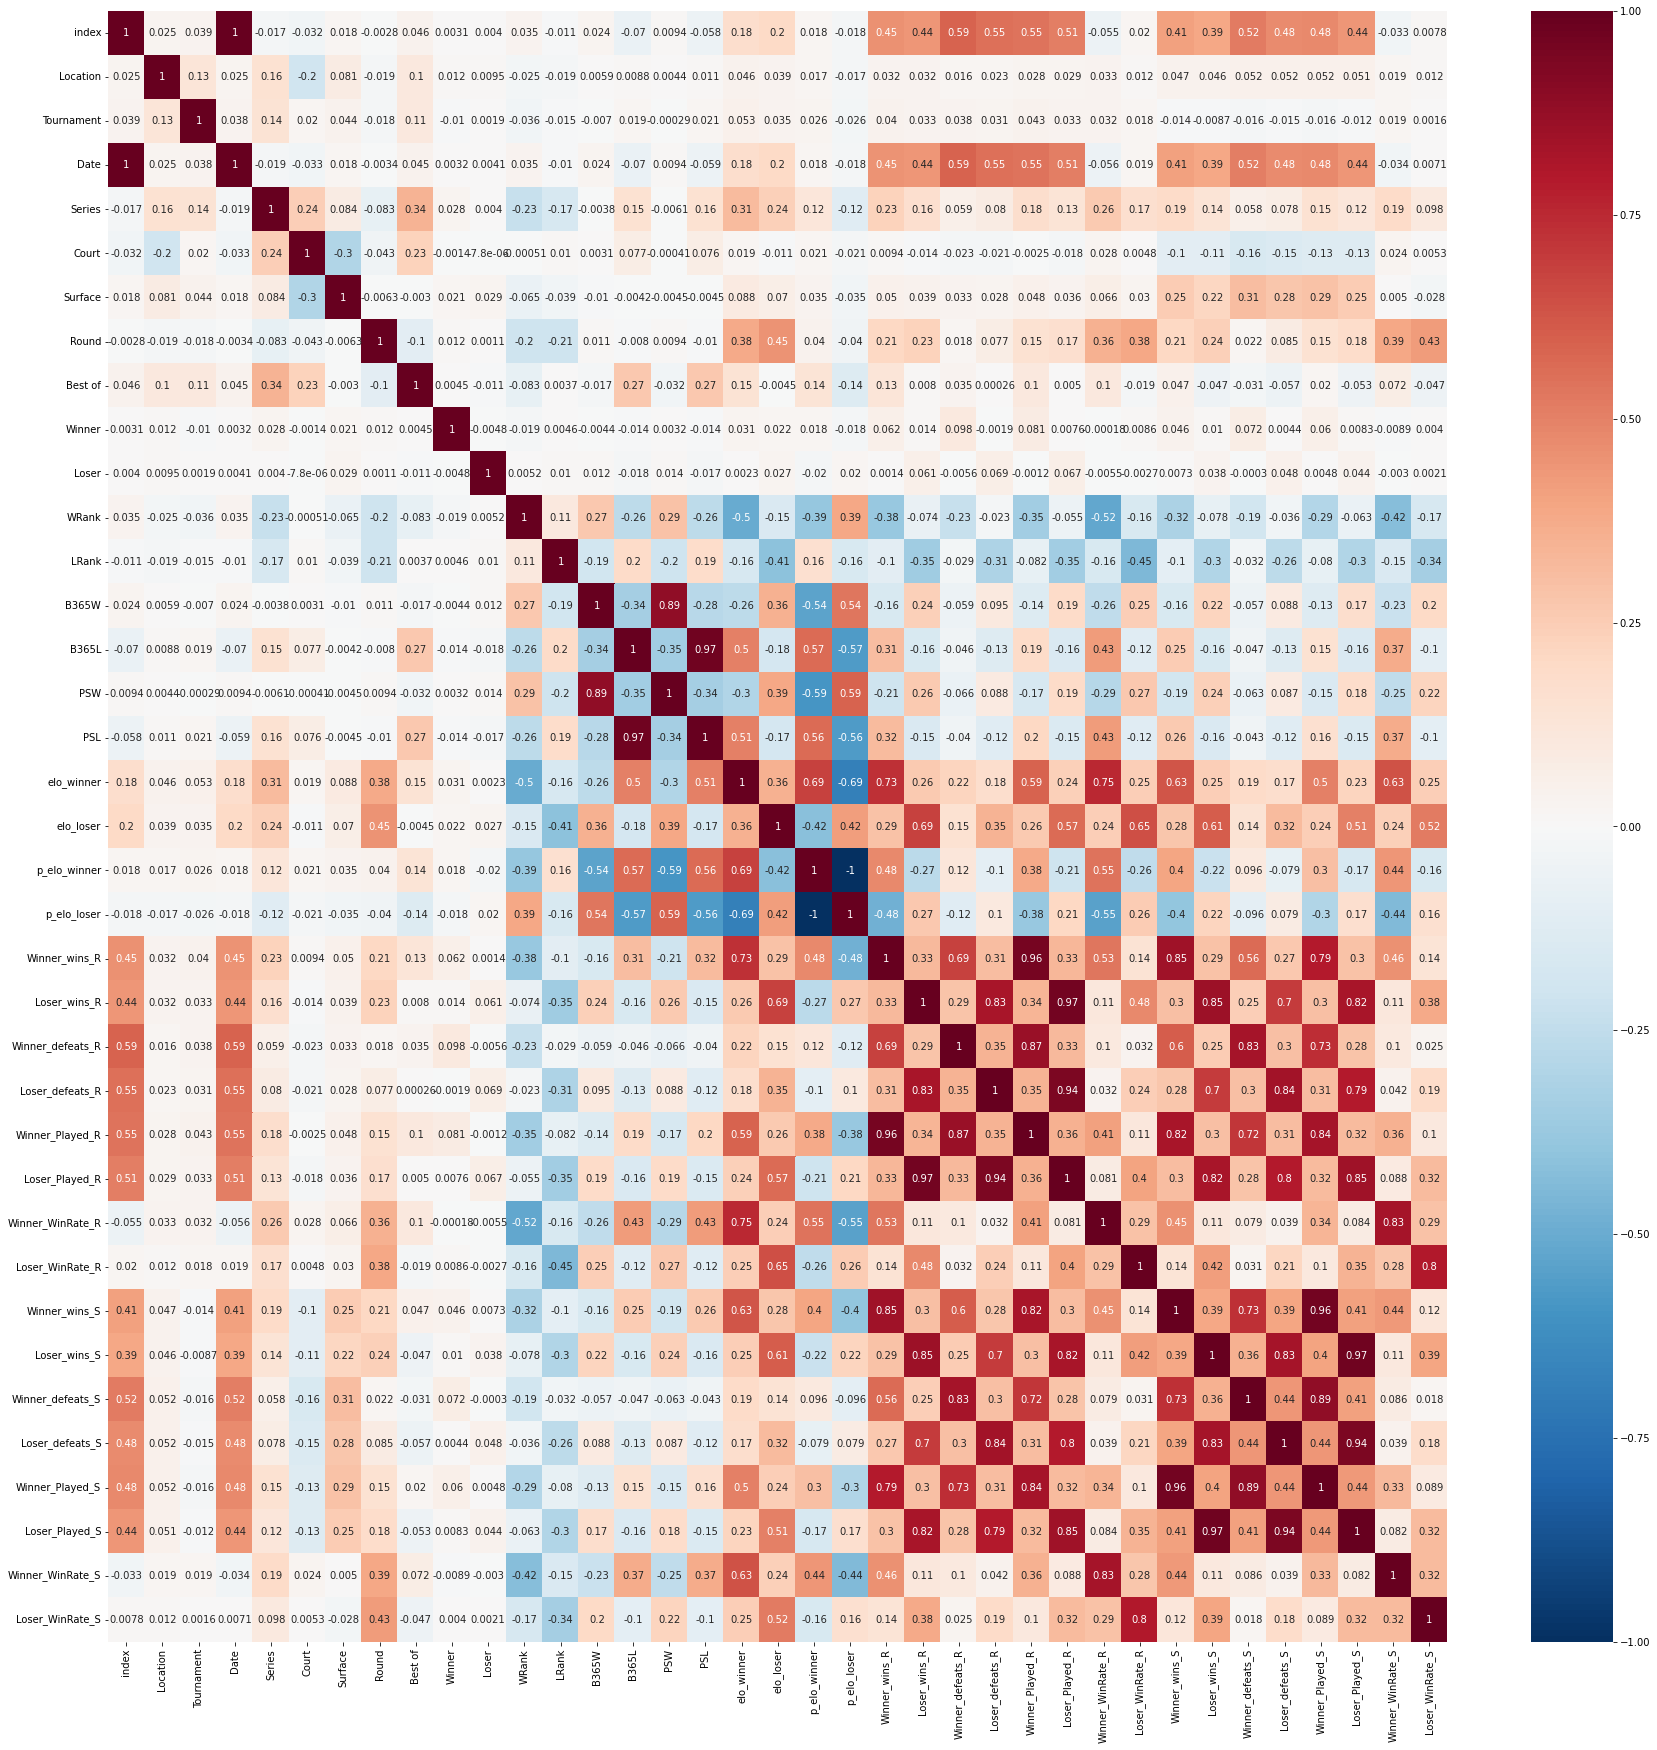

In [35]:
# Heatmap 

plt.figure(figsize=(30,30))
correlation = data_H.corr()
sns.heatmap(correlation,  annot=True, cmap="RdBu_r", center =0);
plt.show()

# **Data Visualization**

**1. Quick view at all the features**

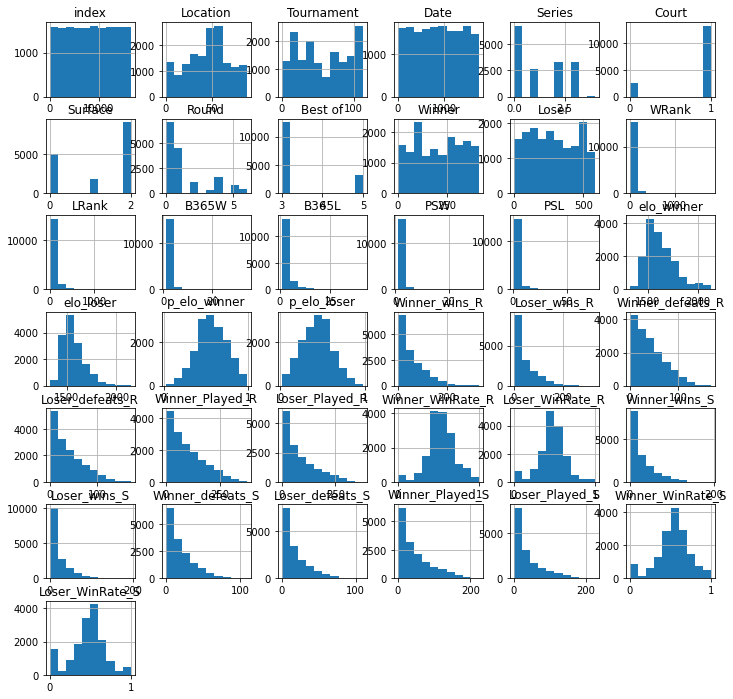

In [36]:
#  used data_h instead of data to allow to check abnormal outliers.

data_H.hist(figsize=(12,12));

**2. By Surface**

In [37]:
data.Surface.value_counts()

Hard     9018
Clay     4956
Grass    1837
Name: Surface, dtype: int64

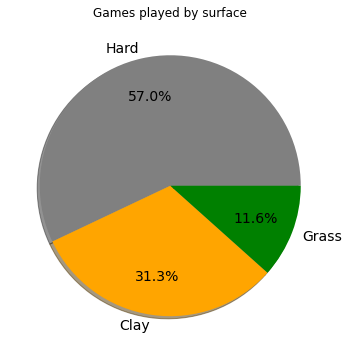

In [38]:
# Surface distribution

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)

ax.pie(x = data.Surface.value_counts(), labels = ['Hard', 'Clay', 'Grass'],
           colors = ['grey', 'orange', 'green'],
           autopct = lambda x: str(round(x, 1)) + '%',
           pctdistance = 0.7, labeldistance = 1.08,
           textprops={'fontsize': 14},
           shadow = True)

ax.set_title('Games played by surface',fontsize = 12);

**3. Series distribution**

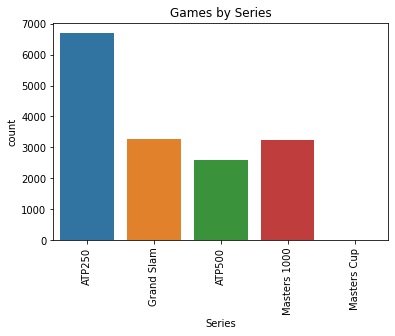

In [39]:
# Games by Series

sns.countplot(x="Series", data=data);
plt.xticks(rotation=90)
plt.title('Games by Series');

**4. Bookmaker odds distribution**

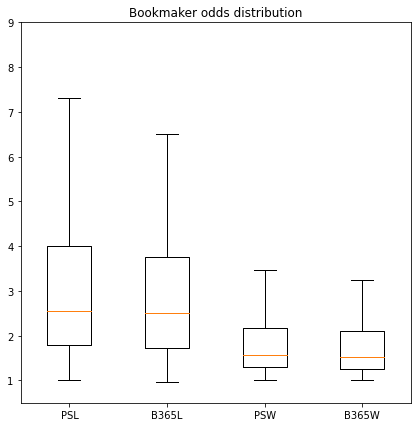

In [40]:

fig = plt.figure(figsize=(7,7))

plt.boxplot([data.PSL,data.B365L,data.PSW,data.B365W],labels=['PSL','B365L','PSW','B365W'],showfliers=False)

plt.ylim(0.5,9)
plt.title('Bookmaker odds distribution');

Bet 365 is slightly less generous than Pinnacle:

- Losers odds are around 3.8 at Pinnacle and 3.5 at Bet 365
- Winner odds are around 1.9 at Pinnacle and 1.8 at Pinnacle

In [41]:
data[['PSL','B365L','PSW','B365W']].describe()

,PSL,B365L,PSW,B365W
count,15811.000000,15811.000000,15811.000000,15811.000000
mean,3.787443,3.459539,1.925299,1.847207
std,4.038042,3.425792,1.241476,1.188151
min,1.010000,0.967000,1.005000,1.002000
25%,1.780000,1.720000,1.290000,1.250000
50%,2.560000,2.500000,1.570000,1.530000
75%,3.995000,3.750000,2.160000,2.100000
max,76.000000,41.000000,31.300000,34.000000


**5. Odds distribution by Year and month** 

In [42]:
data['year'] = pd.to_datetime(data.Date).dt.year
data['month'] = pd.to_datetime(data.Date).dt.month

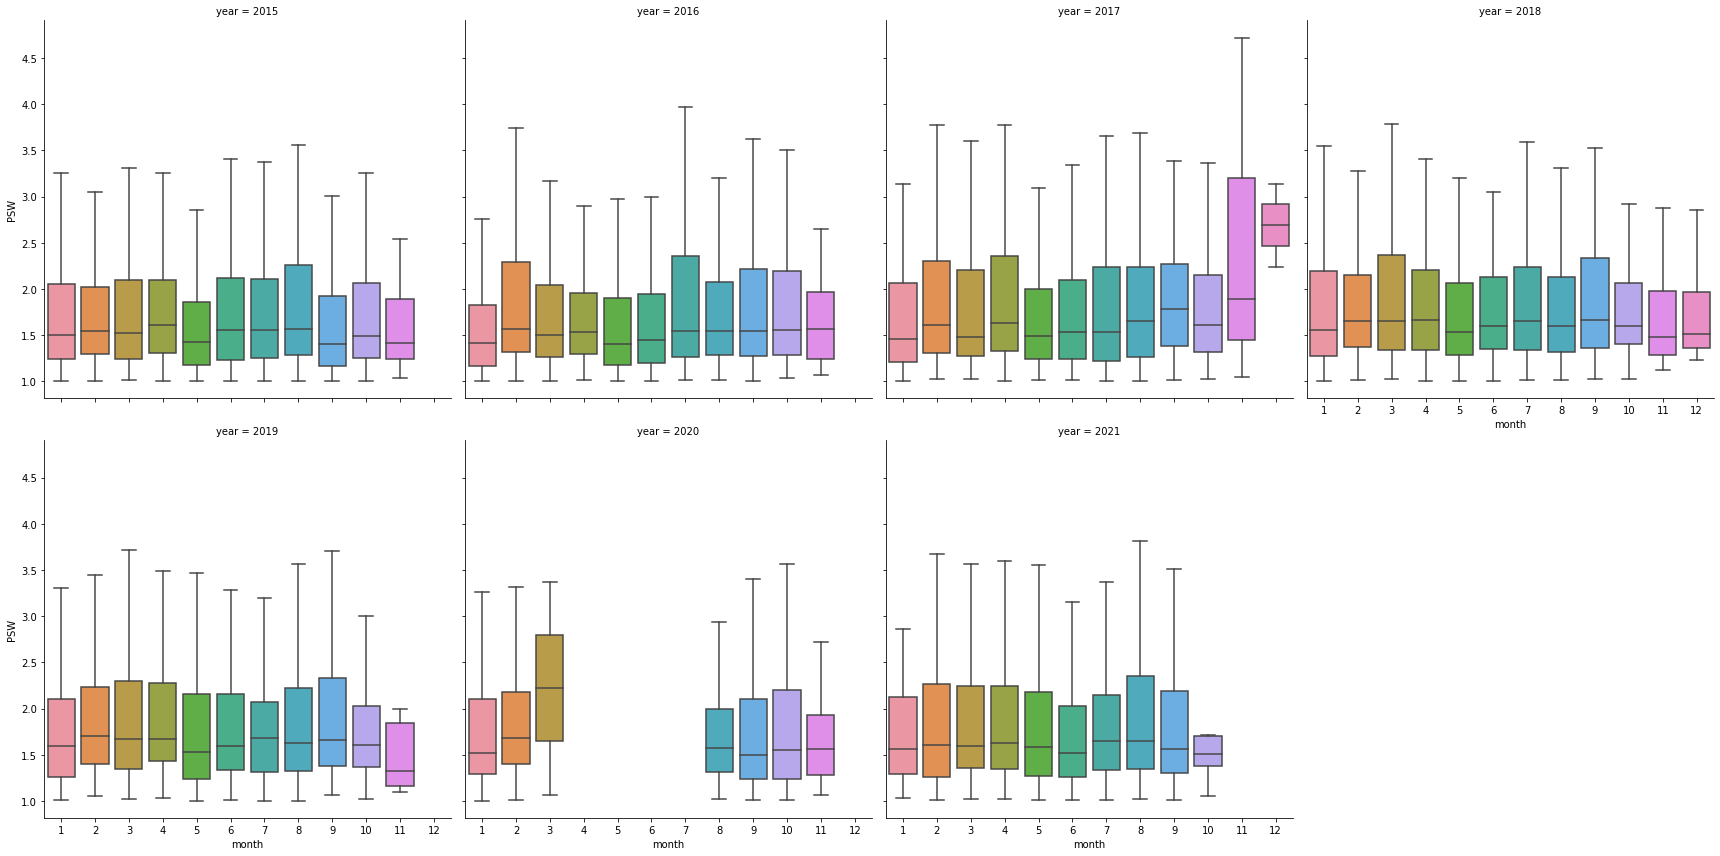

In [43]:
sns.catplot(x="month", y="PSW", col= 'year', kind="box", data=data, col_wrap=4, height=6,showfliers=False);

It seems there are some discrepancies between the periods, let's look at the average montly odds.

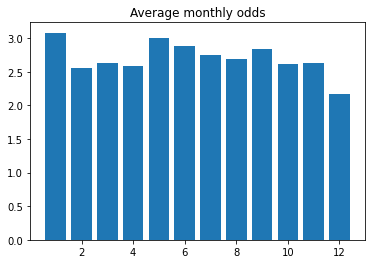

In [44]:
value=[]

for i in range(1,13):
  v1p = data[data['month']==i]['PSW'].mean()
  v2p = data[data['month']==i]['PSL'].mean()
  valuep = (v1p+v2p)/2
  v1b = data[data['month']==i]['B365W'].mean()
  v2b = data[data['month']==i]['B365L'].mean()
  valueb = (v1b+v2b)/2
  value.append((valuep+valueb)/2)
  
plt.bar(range(1,13),value);
plt.title ('Average monthly odds');

There are some variations between the periods but we would need to refine the analysis by checking the tournaments involved.

**6. Odds distribution by Tournament**

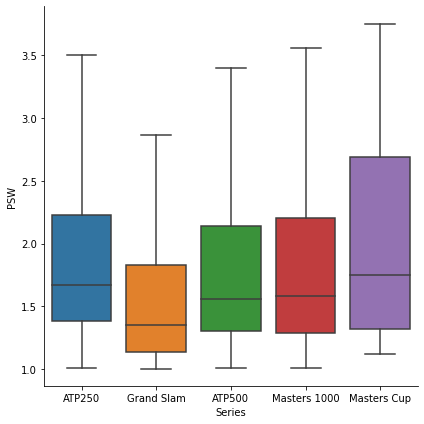

In [45]:
# Let's verify whether the odds depend on the kind of tournament:

sns.catplot(x="Series", y="PSW", kind="box", data=data, height=6,showfliers=False);

The distribution doesn't provide much information. We could expect  ATP250 to have smaller odds than ATP500 or ATP1000 but it doesn't seem to be the case.

Let's now have a look at the different tournaments individually.

In [46]:
data['Tournament'].value_counts()

French Open                    855
Australian Open                848
US Open                        828
Wimbledon                      738
Sony Ericsson Open             457
                              ... 
Mallorca Championships          25
Malaysian Open                  25
Forte Village Sardegna Open     24
Zhuhai Open                     23
Masters Cup                     18
Name: Tournament, Length: 114, dtype: int64

In [47]:
# Let's first create an 'average rate column' to help see which tournaments provide the best odds

data['AVG Odd']=(data['PSW']+data['PSL']+data['B365W']+data['B365L'])/4

# Let's look at the 10 most generous tournaments

data.groupby(by='Tournament').mean().sort_values(by='AVG Odd',ascending=False)['AVG Odd'].head(10)

Tournament
French Open                    3.888008
Wimbledon                      3.710222
Australian Open                3.707455
Belgrade Open                  3.651538
US Open                        3.551861
Qatar Exxon Mobil Open         3.074785
Dubai Tennis Championships     3.028546
Open Banco Sabadell            2.951439
Gerry Weber Open               2.898816
Internazionali BNL d'Italia    2.874486
Name: AVG Odd, dtype: float64

As expected the 4 grand slams tournaments count among the most generous ones.

Let's keep that sort of analysis in mind for the ROI strategy we want to build later.

In [48]:
# Let's now look at the 10 least generous tournaments

data.groupby(by='Tournament').mean().sort_values(by='AVG Odd',ascending=False)['AVG Odd'].tail(10)

Tournament
Rosmalen Grass Court Championships    2.169259
Apia International                    2.165405
Hungarian Open                        2.157500
Forte Village Sardegna Open           2.155937
Heineken Open                         2.147981
Eastbourne International              2.116981
Chile Open                            2.115000
Maharashtra Open                      2.114427
Sydney International                  2.104755
Adelaide International                2.059231
Name: AVG Odd, dtype: float64

We might want to avoid betting on the tournaments with the smallest odds

**7. ELO ranks vs players odds**

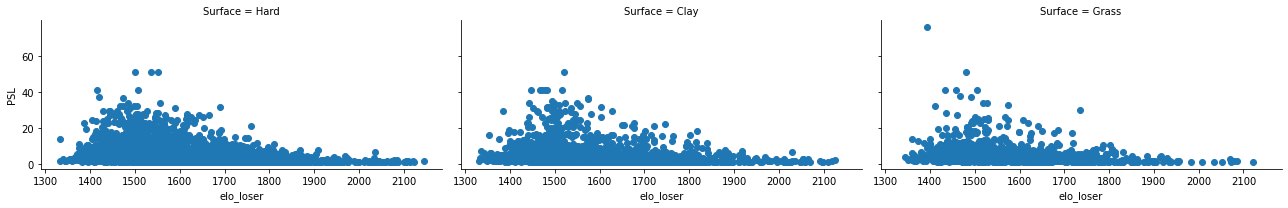

In [49]:
#relationship between losers elo rank and Pinnacle odds according to the Surface

g = sns.FacetGrid(data, col="Surface",aspect=2)
g.map(plt.scatter, "elo_loser", "PSL");



As expected, it seems that there is a negative correlation between the elo_rank and the level of odds. 

**8. ATP ranks vs players odds**

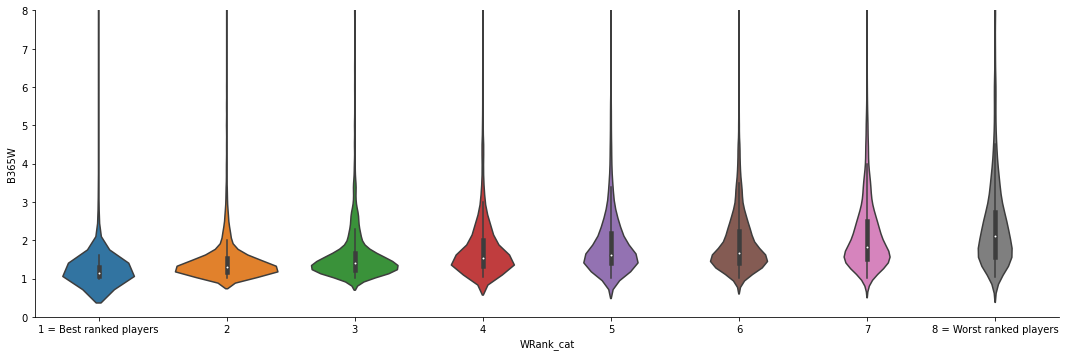

In [50]:
#relation between ATP Rank for winners and B365 odds according to the type of tournament

data['WRank_cat']=pd.qcut(data['WRank'],labels=['1 = Best ranked players','2','3','4','5','6','7','8 = Worst ranked players'],q=8)

ax=sns.catplot(x="WRank_cat", y="B365W", split=True, kind="violin", data=data,showfliers=False,aspect=3)

ax.set(ylim=(0, 8));



AT B365, most odds are between 1 and 4 and they tend to be higher for lower ranked players

**Both Elo and ATP ranks tend to show a negative correlation between players ranks and their odds.**

**9. Winrate vs player odds**

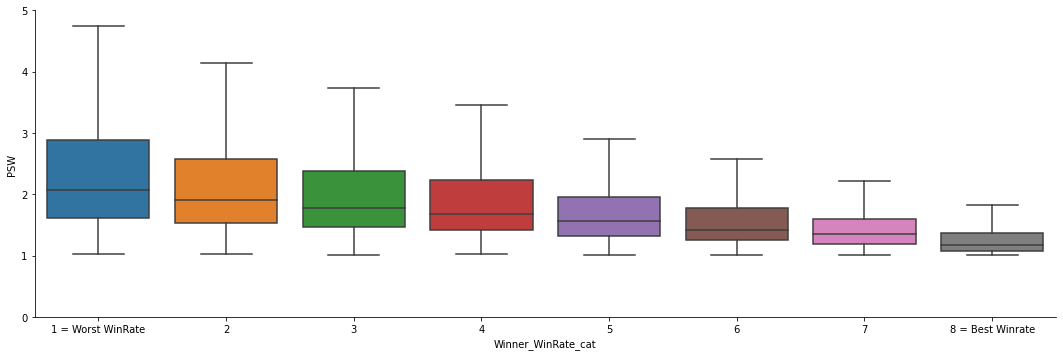

In [51]:
data['Winner_WinRate_cat']=pd.qcut(data['Winner_WinRate_R'],labels=['1 = Worst WinRate','2','3','4','5','6','7','8 = Best Winrate'],q=8)

ax=sns.catplot(x="Winner_WinRate_cat", y="PSW", kind="box", data=data,showfliers=False,aspect=3)

ax.set(ylim=(0, 5));


Here again, it is pretty clear that there is a negative correlation between the Winrate and the level of odds which is something we can remember when building our model.

**10. Study about nb of games played by player**

In [52]:
# Number of Victories/Defeats/Games per player

Victories = pd.DataFrame(data.Winner.value_counts())
Defeats = pd.DataFrame(data.Loser.value_counts())
Games = pd.concat([Victories,Defeats], axis = 1)

# Players index as a column so that we can check duplicates

Games = Games.rename_axis('Players').reset_index()
print('Duplicates:',Games.duplicated().sum())

# NaN generated are replaced with 0 (for example a player has 5 defeats but no victory)

Games.fillna(0,inplace=True)

# Add the number of games played + victory rate

Games['Played']=Games['Winner']+Games['Loser']
Games['%Win']=Games['Winner']/Games['Played']

print('\n',Games.head(),'\n','\n',Games.tail())

Duplicates: 0

        Players  Winner  Loser  Played      %Win
0  Djokovic N.   333.0   46.0   379.0  0.878628
1     Nadal R.   290.0   58.0   348.0  0.833333
2    Zverev A.   260.0  113.0   373.0  0.697051
3     Thiem D.   248.0  113.0   361.0  0.686981
4   Federer R.   232.0   45.0   277.0  0.837545 
 
             Players  Winner  Loser  Played  %Win
584  Huta Galung J.     0.0    1.0     1.0   0.0
585          Luz O.     0.0    1.0     1.0   0.0
586    Sarmiento R.     0.0    1.0     1.0   0.0
587     Eriksson M.     0.0    1.0     1.0   0.0
588   Barrientos N.     0.0    1.0     1.0   0.0


In [53]:
Games['Played'].describe()

count    589.000000
mean      53.687606
std       83.423032
min        1.000000
25%        2.000000
50%       11.000000
75%       69.000000
max      379.000000
Name: Played, dtype: float64

Mean value is 53 games per player where median value is 10 games only.  
-> 50% of the players have played less than 10 games and 1/4 of them less than 2 games.

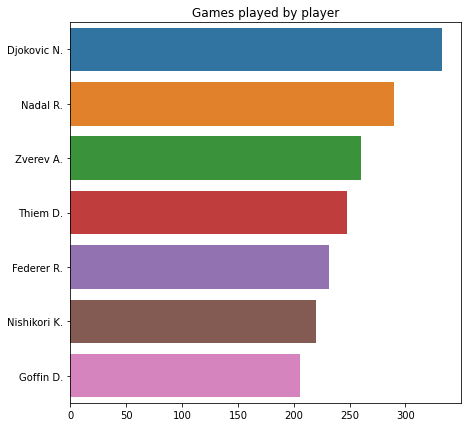

In [54]:
plt.figure(figsize=(7,7))
sns.barplot(y=data.Winner.value_counts().head(7).index,
            x=data.Winner.value_counts().head(7).values);


plt.title('Games played by player');

Some players have been in much more games. Let's look at the top 20:

In [55]:

TOP20 = Games['Played'][Games['Players'].head(20).index].sum()
TOP20_R = TOP20/Games['Played'].sum()
print("TOP20 players have played", "{0:.0%}".format(TOP20_R), "of the games")


TOP20 players have played 19% of the games


Conclusion: Despite some players have been in much more games and some other players in very few games, taking off their data doesn't seem to lead to a better peformance so we won't follow that path.